In [23]:
from dataclasses import astuple
import os
from pathlib import Path 
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
sys.path.insert(0, str(Path().absolute().parents[1]))

from experiments.datasets.faces import FaceImage, FaceAnnotation
from cv_prince.chap_07_complex_densities.gmm import ExpectationMaximisationGMM

In [24]:
root_data_dir = os.environ.get("DATASETS")
data_dir = Path(root_data_dir) / "FDDB"
faces_dir = data_dir / "originalPics"
fold_dir = data_dir / "FDDB-folds"

fold_id = 1

fold_file = fold_dir / f"FDDB-fold-{fold_id:02d}.txt"
fold_ellipse_file = fold_dir / f"FDDB-fold-{fold_id:02d}-ellipseList.txt"

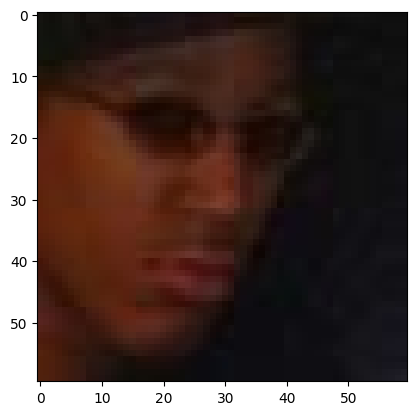

In [25]:
import scipy.io
mat = scipy.io.loadmat(Path(root_data_dir)/'face_cv_prince/FaceNonFace.mat')
plt.imshow(mat["face"][..., 700])

In [26]:
test_fold = 10
val_folds = [8, 9]
train_folds = [1, 2, 3, 4, 5, 6, 7]

In [27]:
face_images_per_folds: dict[int, list[FaceImage]] = {}

for fold_ellipse_file in sorted(fold_dir.glob("FDDB-fold-*")):
    if not fold_ellipse_file.name.endswith("ellipseList.txt"):
        continue

    fold_id = int(fold_ellipse_file.name.split("-")[-2])
    face_images: list[FaceImage] = []

    with open(fold_ellipse_file, "r") as fid:
        while True:
            line = fid.readline()
            
            if not line:
                break

            if line.endswith("\n"):
                line = line[:-1]

            assert line.startswith("2002") or line.startswith("2003")
            
            face_img_path = faces_dir / (line + ".jpg")
            num_faces = int(fid.readline())
            face_image = FaceImage(file_path=face_img_path, num_faces=num_faces)
            
            for _ in range(num_faces):
                face_anno = FaceAnnotation.from_str(fid.readline())
                face_image.add_face(face_anno)

            face_images.append(face_image)
    
    face_images_per_folds[fold_id] = face_images

In [28]:
train_faces = []
train_non_faces = []
data_size = (24, 24)

for fold_id in train_folds:
    face_images = face_images_per_folds[fold_id]

    for face_image in face_images:

        if len(train_faces) < 1000:
            tallest_face = face_image.get_tallest_face()

            cropped_face = face_image.crop_face_img(tallest_face)
            cropped_face = cropped_face.convert("L")
            cropped_face = cropped_face.resize(data_size)
            train_faces.append(np.asarray(cropped_face))

        if len(train_non_faces) < 1000:
            try:
                non_face = face_image.crop_non_face_img(
                    seed=12345, max_overlap=0.15, num_instances=1, max_trials=100
                )[0]
            except IndexError:
                continue

            non_face = non_face.convert("L")
            non_face = non_face.resize(data_size)
            train_non_faces.append(np.asarray(non_face))

print(len(train_faces))
print(len(train_non_faces))

1000
1000


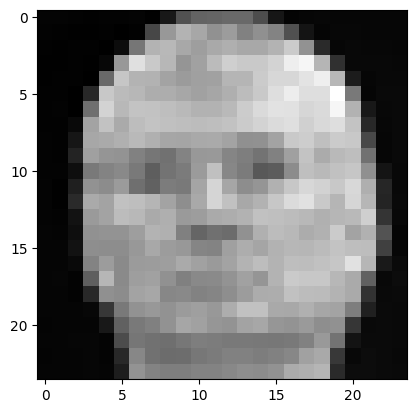

In [29]:
plt.imshow(train_faces[30], cmap="gray")

In [ ]:
train_faces_arr = np.stack(train_faces, axis=0)
train_faces_arr = np.reshape(train_faces_arr, (train_faces_arr.shape[0], -1))
train_faces_arr = train_faces_arr.astype(np.float64)
train_faces_arr /= 255.0
# face_means = np.mean(train_faces_arr, axis=0)
# train_faces_arr -= face_means[np.newaxis, ...]
print(train_faces_arr.shape)

train_non_faces_arr = np.stack(train_non_faces, axis=0)
train_non_faces_arr = np.reshape(train_non_faces_arr, (train_non_faces_arr.shape[0], -1))
train_non_faces_arr = train_non_faces_arr.astype(np.float64)
train_non_faces_arr /= 255.0
# face_std = np.std(train_faces_arr, axis=0)
# train_faces_arr /= face_std[np.newaxis, ...]
print(train_non_faces_arr.shape)

(1000, 576)
(1000, 576)


In [31]:
num_samples = train_faces_arr.shape[0]

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=12345)
labels = kmeans.fit_predict(train_faces_arr)

one_hot_encoding = np.zeros((num_samples, 10), dtype=bool)
np.put_along_axis(one_hot_encoding, labels[:, None], 1, axis=1)

weights = one_hot_encoding.sum(axis=0) / num_samples

means = np.zeros(one_hot_encoding.shape + train_faces_arr.shape[-1:])
means[one_hot_encoding, :] = train_faces_arr
means = means.sum(axis=0)
means /= one_hot_encoding.sum(axis=0)[:, None]

covs = []

eps = 10 * np.finfo(np.float64).eps
diffs = train_faces_arr - means[labels, :]

covs = np.stack(
    [
        diffs[labels==i].T @ diffs[labels==i] / (diffs[labels==i].shape[0] + eps)
        for i in range(10)
    ]
)
covs += 1e-6 * np.eye(covs.shape[-1])[None, :]

In [34]:
gmm = GaussianMixture(n_components=10, random_state=12345, init_params="random_from_data")
gmm._initialize_parameters(train_faces_arr, random_state=np.random.RandomState(gmm.random_state))

In [ ]:
faces_em_fitter = ExpectationMaximisationGMM(num_components=10, seed=12345)

faces_em_fitter.initialise_params(train_faces_arr)
faces_em_fitter.ndims = train_faces_arr.shape[1]
faces_em_fitter.weights = gmm.weights_
faces_em_fitter.means = gmm.means_
faces_em_fitter.covs = gmm.covariances_

In [37]:
faces_em_fitter.fit(train_faces_arr)
scipy_prediction = gmm.fit_predict(train_faces_arr)

  0%|          | 3/1000 [00:32<2:58:00, 10.71s/it]


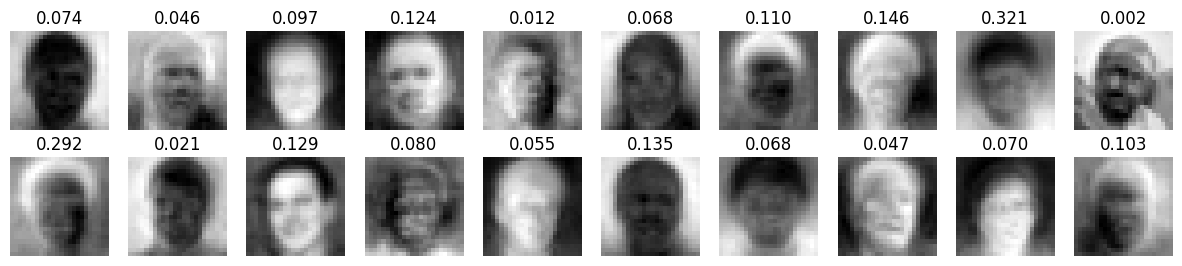

In [38]:
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
    axes[0, i].imshow(gmm.means_[i, ...].reshape((24, 24)), cmap="gray")
    axes[1, i].imshow(faces_em_fitter.means[i, ...].reshape((24, 24)), cmap="gray")

    axes[0,i].set_title(f"{gmm.weights_[i]:.3f}")
    axes[0,i].set_axis_off()
    axes[1,i].set_title(f"{faces_em_fitter.weights[i]:.3f}")
    axes[1,i].set_axis_off()

In [39]:
img_with_most_faces = face_images[0]
for face_image in face_images[1:]:
    if face_image.num_faces > img_with_most_faces.num_faces:
        img_with_most_faces = face_image

k = 5
img_with_k_faces = None
for face_image in face_images:
    if face_image.num_faces == k:
        img_with_k_faces = face_image
        break

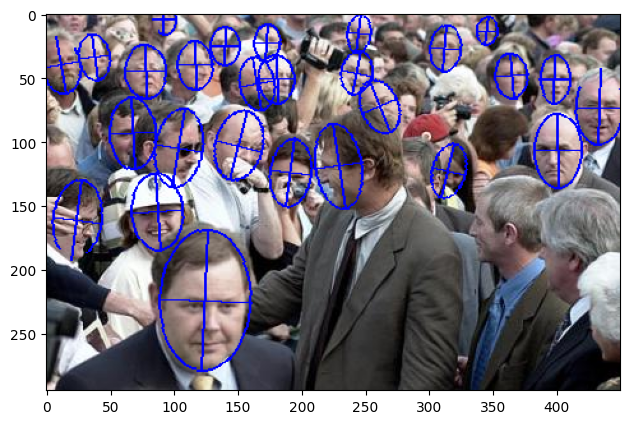

In [ ]:
face_image = img_with_most_faces
img = face_image.show_annotated_image()

plt.imshow(img)

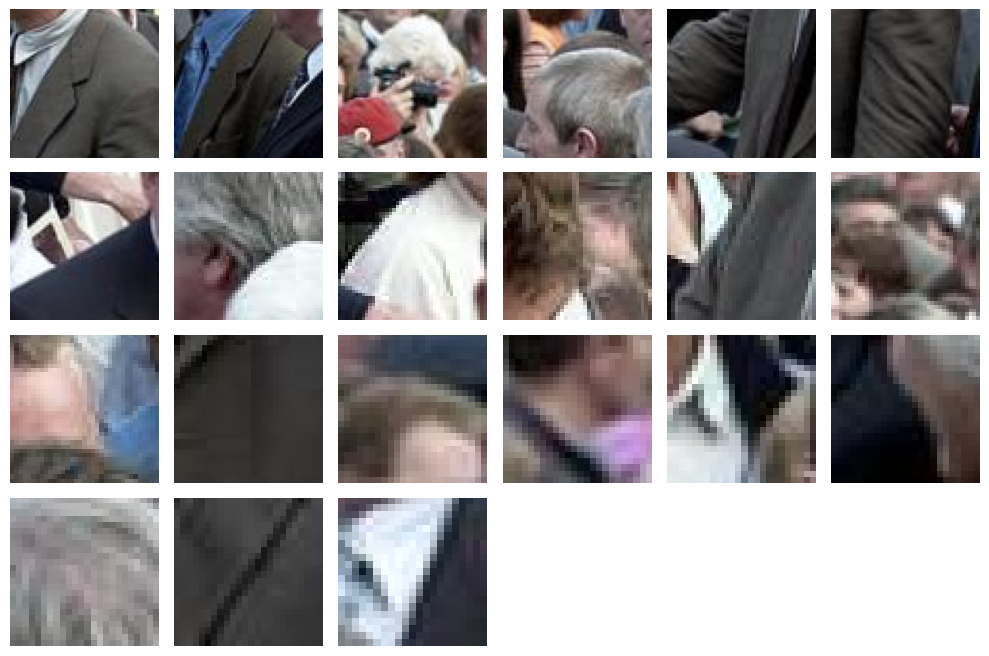

In [51]:
num_instances = None
res = face_image.crop_non_face_img(
    seed=12345, max_overlap=0.1, num_instances=num_instances
)

num_cols = 6
num_rows = int(np.ceil(len(res) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 10 / num_cols))

for ax, non_face_img in zip(axes.flatten(), res):
    ax.imshow(non_face_img)
    ax.set_axis_off()

num_img_in_last_row = num_faces % num_cols
if num_img_in_last_row > 0:
    for i in range(num_cols-num_img_in_last_row):
        fig.delaxes(axes.flat[-i-1])

fig.tight_layout()

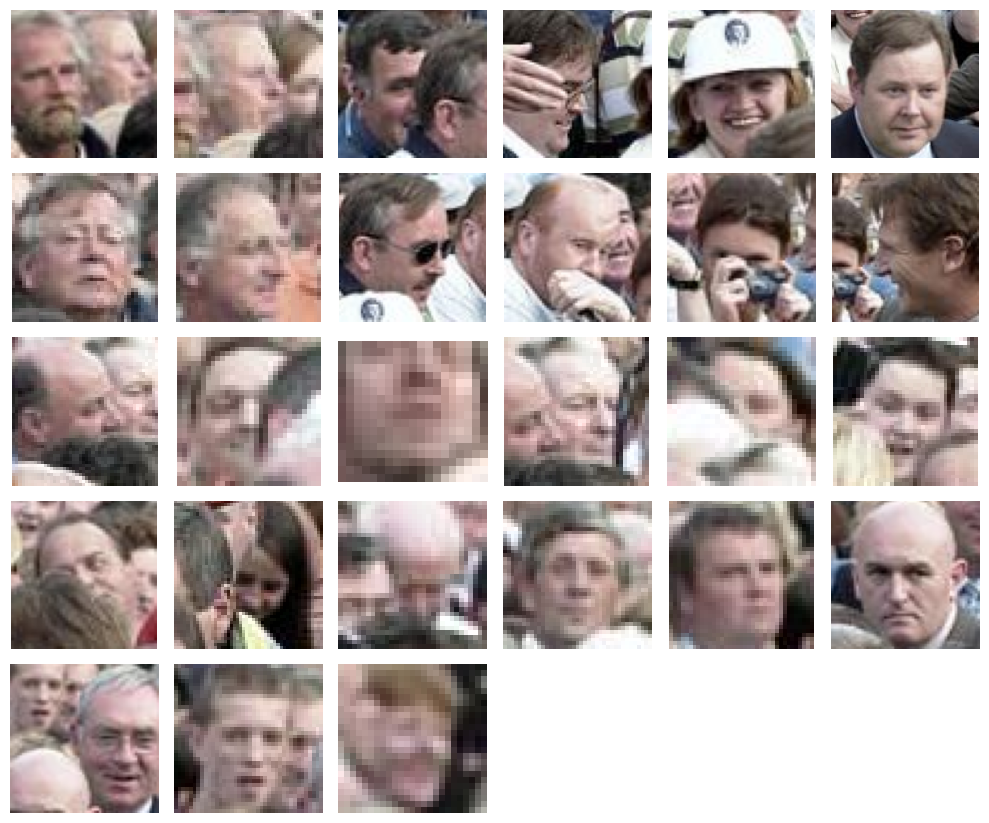

In [50]:
num_faces = face_image.num_faces

num_rows = int(np.ceil(num_faces / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 10 / num_cols))

for ax, cropped_face in zip(axes.flatten(), face_image.get_all_croped_faces()):
    ax.imshow(cropped_face, cmap="gray")
    ax.set_aspect("equal")
    ax.set_axis_off()

num_img_in_last_row = num_faces % num_cols
if num_img_in_last_row > 0:
    for i in range(num_cols-num_img_in_last_row):
        fig.delaxes(axes.flat[-i-1])

fig.tight_layout()